In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Configuration
# On détecte si un GPU est disponible (cuda pour Nvidia, mps pour Mac M1/M2)
if torch.cuda.is_available():
    DEVICE = "cuda"
elif torch.backends.mps.is_available():
    DEVICE = "mps"
else:
    DEVICE = "cpu"

print(f"Appareil utilisé : {DEVICE}")

BATCH_SIZE = 128
LR = 1e-4
EPOCHS = 1       # Pour des résultats parfaits, augmenter à 20+
TIMESTEPS = 500  # Nombre d'étapes de diffusion
IMG_SIZE = 28

Appareil utilisé : cpu


In [2]:
# Transformation pour normaliser les images entre [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

# Téléchargement de MNIST
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

# Dataset de test pour la visualisation
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

print("Données chargées.")

Données chargées.


In [3]:
class DiffusionUtils:
    def __init__(self, timesteps=TIMESTEPS, start=0.0001, end=0.02, device=DEVICE):
        self.timesteps = timesteps
        self.device = device
        self.betas = torch.linspace(start, end, timesteps).to(device)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, axis=0)
        
    def forward_noise(self, x_0, t):
        """
        Ajoute du bruit à l'image x_0 à l'instant t.
        Retourne l'image bruitée et le bruit lui-même.
        """
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None, None, None]
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod[t])[:, None, None, None]
        
        noise = torch.randn_like(x_0)
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * noise, noise

    def sample_timesteps(self, n):
        """Retourne des indices de temps aléatoires."""
        return torch.randint(0, self.timesteps, (n,), device=self.device)

diff_utils = DiffusionUtils()

In [4]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.n_embd = n_embd
        # La première couche prend n_embd // 4 en entrée (car on concatène sin et cos)
        self.lin1 = nn.Linear(self.n_embd // 4, self.n_embd)
        self.lin2 = nn.Linear(self.n_embd, self.n_embd)

    def forward(self, t):
        # Calcul dynamique de la demi-dimension pour éviter les erreurs
        half_dim = self.lin1.in_features // 2
        
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)
        
        return self.lin2(F.silu(self.lin1(emb)))

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # --- CORRECTION : On aligne time_dim sur la taille du bottleneck (256) ---
        time_dim = 256
        self.time_mlp = TimeEmbedding(time_dim)

        # Encoder (Descente)
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)

        # Bottleneck (Le goulot d'étranglement)
        self.bot1 = nn.Conv2d(128, 256, 3, padding=1) # Sortie 256 canaux
        self.bot2 = nn.Conv2d(256, 128, 3, padding=1)

        # Decoder (Remontée)
        self.up1 = nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1)
        self.up2 = nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1)
        self.out = nn.Conv2d(32, 1, 3, padding=1)

    def forward(self, x, t):
        # Encodage du temps
        t_emb = self.time_mlp(t)
        # On étend les dimensions pour l'addition : (Batch, 256, 1, 1)
        t_emb = t_emb[:, :, None, None] 
        
        # Encoder
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x1))
        x3 = F.relu(self.conv3(x2))

        # Bottleneck
        x_bot = F.relu(self.bot1(x3))
        
        # --- Injection du temps (ADDITION) ---
        # Ici, x_bot est (Batch, 256, H, W) et t_emb est (Batch, 256, 1, 1)
        # Grâce au broadcasting, cela fonctionne parfaitement maintenant.
        x_bot = x_bot + t_emb 
        
        x_bot = F.relu(self.bot2(x_bot))
        
        # Decoder
        x_up1 = F.relu(self.up1(x_bot + x3)) 
        x_up2 = F.relu(self.up2(x_up1 + x2))
        
        return self.out(x_up2 + x1)

model = SimpleUNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()
print("Modèle U-Net prêt et vérifié.")

Modèle U-Net prêt et vérifié.


Epoch 1/1: 100%|██████████| 468/468 [02:06<00:00,  3.69it/s, MSE=0.209]


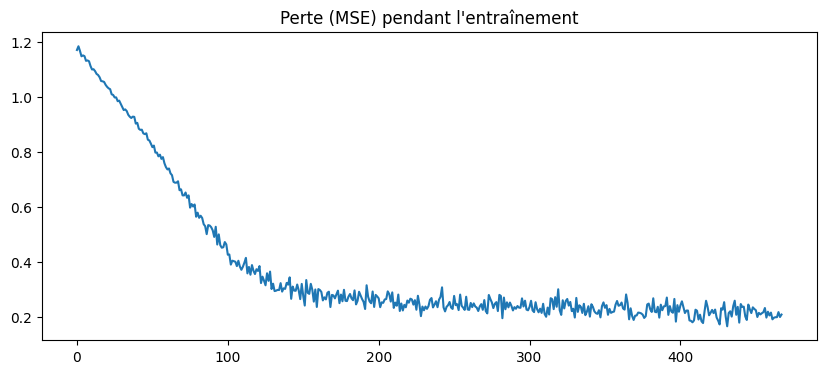

In [5]:
losses = []

for epoch in range(EPOCHS):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    for batch in pbar:
        optimizer.zero_grad()
        images, _ = batch
        images = images.to(DEVICE)
        
        # 1. On choisit des t aléatoires
        t = diff_utils.sample_timesteps(images.shape[0]).float()
        
        # 2. On bruite les images
        x_t, noise = diff_utils.forward_noise(images, t.long())
        
        # 3. Le modèle essaie de prédire le bruit
        noise_pred = model(x_t, t)
        
        # 4. Calcul de l'erreur et mise à jour
        loss = criterion(noise_pred, noise)
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pbar.set_postfix(MSE=loss.item())

# Afficher la courbe de perte
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("Perte (MSE) pendant l'entraînement")
plt.show()

In [6]:
@torch.no_grad()
def reconstruct_cycle(model, diff_utils, original_img, t_start=300, save_steps=[200, 100, 50]):
    model.eval()
    
    # --- ENCODAGE (Ajout de bruit partiel) ---
    # On ne va pas jusqu'à 500 (bruit total), on s'arrête avant pour garder la structure
    t_tensor = torch.tensor([t_start]).to(DEVICE)
    noised_img, _ = diff_utils.forward_noise(original_img, t_tensor)
    
    history = []
    history.append(('Original', (original_img.clamp(-1, 1) + 1) / 2))
    history.append((f'Noised (t={t_start})', (noised_img.clamp(-1, 1) + 1) / 2))
    
    # --- DÉCODAGE (Suppression du bruit) ---
    x = noised_img.clone()
    
    # On remonte le temps de t_start vers 0
    for i in tqdm(reversed(range(1, t_start)), desc="Reconstruction", total=t_start-1):
        t = (torch.ones(x.shape[0]) * i).long().to(DEVICE)
        
        predicted_noise = model(x, t.float())
        
        alpha = diff_utils.alphas[t][:, None, None, None]
        alpha_hat = diff_utils.alphas_cumprod[t][:, None, None, None]
        beta = diff_utils.betas[t][:, None, None, None]
        
        if i > 1:
            noise = torch.randn_like(x)
        else:
            noise = torch.zeros_like(x)
            
        # Formule de sampling DDPM
        x = (1 / torch.sqrt(alpha)) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        
        if i in save_steps:
            img_disp = (x.clamp(-1, 1) + 1) / 2
            history.append((f'Step {i}', img_disp.cpu()))

    final_img = (x.clamp(-1, 1) + 1) / 2
    history.append(('Reconstructed', final_img.cpu()))
    
    model.train()
    return history

Reconstruction: 100%|██████████| 299/299 [00:00<00:00, 500.97it/s]


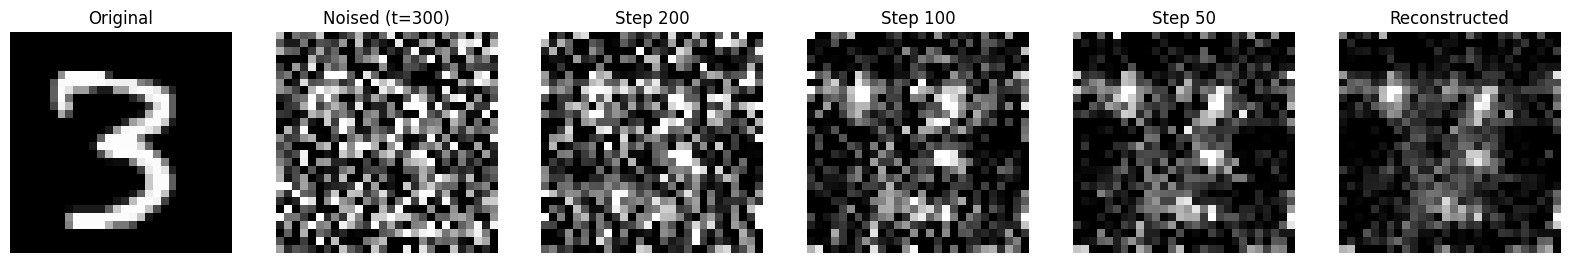

In [7]:
# 1. Prendre une image de test
img_original, _ = next(iter(test_loader))
img_original = img_original.to(DEVICE)

# 2. Lancer le cycle
# t_start=300 signifie qu'on détruit environ 60% de l'image avant de la reconstruire.
# Plus t_start est grand, plus la reconstruction sera créative (et moins fidèle).
steps = reconstruct_cycle(model, diff_utils, img_original, t_start=300, save_steps=[200, 100, 50])

# 3. Afficher
fig, axes = plt.subplots(1, len(steps), figsize=(20, 4))
for i, (title, img) in enumerate(steps):
    axes[i].imshow(img[0, 0], cmap='gray')
    axes[i].set_title(title)
    axes[i].axis('off')
plt.show()